In [1]:
import os
import time
import math
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
from einops import rearrange, repeat
from timm.models.vision_transformer import Block


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from Utils import output_metric, plot_confusion_matrix
from CNNUtils import train, test, valid
from Utils import list_to_colormap, classification_map, print_args
from Utils import ActivationOutputData


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("MViT")
parser.add_argument('--dataset', choices=['LongKou', 'HanChuan', 'HongHu', 'Pavia'], default='Pavia', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=25, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'LongKou':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    label = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [624, 354, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (225, 15, 15, 30), type = float64
x_test  shape = (42551, 15, 15, 30), type = float64
x_valid  shape = (900, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (225,), type = int64
y_test: shape = (42551,), type = int64
y_valid: shape = (900,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[409, 293],
       [404, 298],
       [380, 301],
       [551,  14],
       [453, 165],
       [140, 172],
       [471, 169],
       [175, 187],
       [482, 185],
       [214, 200]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)  # (90, 30, 15, 15)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)  # (5198, 30, 15, 15)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)  # (5211, 30, 15, 15)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=30, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([225, 1, 30, 15, 15])
torch.Size([42551, 1, 30, 15, 15])
torch.Size([900, 1, 30, 15, 15])


## Model

In [11]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  32

    pos = pos.reshape(-1)  # (M, )  169
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

In [12]:
class MViT(nn.Module):
    def __init__(self, in_chans=1, bands=30, num_classes=9, dim=64, heads=4, depth=3, dropout=0.2):
        super(MViT, self).__init__()
        self.conv3d = nn.Sequential(nn.Conv3d(1, 8, 3), nn.BatchNorm3d(8), nn.ReLU())
        self.conv2d = nn.Sequential(nn.Conv2d(8*28, 64, 3), nn.BatchNorm2d(64), nn.ReLU())

        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        nn.init.normal_(self.cls_token, std=.02)

        self.pos_embed = nn.Parameter(torch.zeros(1, 121 + 1, dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(dim, 11, cls_token=True) 
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.blocks = nn.ModuleList([Block(dim, heads, qkv_bias=True, attn_drop=0.1, drop=0.1) for _ in range(depth)])

        self.norm = nn.LayerNorm(dim)
        
        self.cls_head = nn.Linear(dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def random_masking(self, x, mask_ratio=0.75):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]  (N, L)
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # 从小到大排序，返回索引 (N, L)
        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        return x_masked

    def forward(self, x, mask_ratio=0.75):
        # (B, 1, 30, 15, 15)
        x = self.conv3d(x)  # (B, 8, 28, 13, 13)
        x = rearrange(x, 'b c d h w -> b (c d) h w')  # (B, 224, 13, 13)
        x = self.conv2d(x)  # (B, 64, 11, 11)
        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, 121, 64) 

        x = x + self.pos_embed[:, 1:, :]

        center_embed = x[:, 60, :].unsqueeze(1)  # (B, 1, 64)
        x = torch.cat([x[:, :60, :], x[:, 61:, :]], dim=1)  # (B, 120, 64)
        
        if self.training:
            x = self.random_masking(x, mask_ratio)  # (B, 30, 64)

        x = torch.cat([center_embed, x], dim=1)

        cls_token = self.cls_token + self.pos_embed[:, :1, :] 
        cls_token = repeat(cls_token, '1 n d -> b n d', b = x.shape[0])  # (B, 1, 64)
        
        x = torch.cat((cls_token, x), dim = 1)

        x = self.dropout(x)  # (B, 31, 64)

        for blk in self.blocks:
            x = blk(x)

        latent = self.norm(x[:, 0, :])
        x = self.cls_head(latent)
        return x

In [13]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)

In [14]:
model = MViT(num_classes=num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [15]:
model_summary(model)

cls_token: 1x1x64 = 64
conv3d.0.weight: 8x1x3x3x3 = 216
conv3d.0.bias: 8
conv3d.1.weight: 8
conv3d.1.bias: 8
conv2d.0.weight: 64x224x3x3 = 129024
conv2d.0.bias: 64
conv2d.1.weight: 64
conv2d.1.bias: 64
blocks.0.norm1.weight: 64
blocks.0.norm1.bias: 64
blocks.0.attn.qkv.weight: 192x64 = 12288
blocks.0.attn.qkv.bias: 192
blocks.0.attn.proj.weight: 64x64 = 4096
blocks.0.attn.proj.bias: 64
blocks.0.norm2.weight: 64
blocks.0.norm2.bias: 64
blocks.0.mlp.fc1.weight: 256x64 = 16384
blocks.0.mlp.fc1.bias: 256
blocks.0.mlp.fc2.weight: 64x256 = 16384
blocks.0.mlp.fc2.bias: 64
blocks.1.norm1.weight: 64
blocks.1.norm1.bias: 64
blocks.1.attn.qkv.weight: 192x64 = 12288
blocks.1.attn.qkv.bias: 192
blocks.1.attn.proj.weight: 64x64 = 4096
blocks.1.attn.proj.bias: 64
blocks.1.norm2.weight: 64
blocks.1.norm2.bias: 64
blocks.1.mlp.fc1.weight: 256x64 = 16384
blocks.1.mlp.fc1.bias: 256
blocks.1.mlp.fc2.weight: 64x256 = 16384
blocks.1.mlp.fc2.bias: 64
blocks.2.norm1.weight: 64
blocks.2.norm1.bias: 64
blocks.2

In [16]:
print('start training')
acc_list = [0.00]
path = './model/mvit.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to mvit.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 1.6067 - train_acc: 51.1111 - valid_loss: 1.1238 - valid_acc: 61.1111
val_acc improved from 0.0000 to 61.1111, saving model to mvit.pt
Epoch: 002 - train_loss: 0.8233 - train_acc: 77.7778 - valid_loss: 0.5899 - valid_acc: 85.4444
val_acc improved from 61.1111 to 85.4444, saving model to mvit.pt
Epoch: 003 - train_loss: 0.5285 - train_acc: 88.8889 - valid_loss: 0.4624 - valid_acc: 88.8889
val_acc improved from 85.4444 to 88.8889, saving model to mvit.pt
Epoch: 004 - train_loss: 0.4043 - train_acc: 89.3333 - valid_loss: 0.3856 - valid_acc: 88.6667
val_acc did not improve from 88.8889
Epoch: 005 - train_loss: 0.3262 - train_acc: 93.3333 - valid_loss: 0.4242 - valid_acc: 86.6667
val_acc did not improve from 88.8889
Epoch: 006 - train_loss: 0.2600 - train_acc: 92.4445 - valid_loss: 0.2695 - valid_acc: 91.4445
val_acc improved from 88.8889 to 91.4445, saving model to mvit.pt
Epoch: 007 - train_loss: 0.1869 - train_acc: 96.4445 - valid_loss: 0.3494 - va

In [17]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [18]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 97.18, AA: 96.70, Kappa: 0.9626
*******************************************************************
Recal: [ 96.96  97.81  86.79  96.22 100.   100.   100.    95.11  97.4 ]
*******************************************************************
Parameter:
dataset: Pavia
seed: 42
batch_size: 30
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 25
*******************************************************************


In [19]:
average_accuracy = str(list(AA_test))
file_name = "./CR/mvit_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [20]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [21]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (42776, 15, 15, 30), type = float64
x_backward  shape = (164624, 15, 15, 30), type = float64
*******************************************************


In [22]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([42776, 1, 30, 15, 15])
torch.Size([164624, 1, 30, 15, 15])


In [23]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

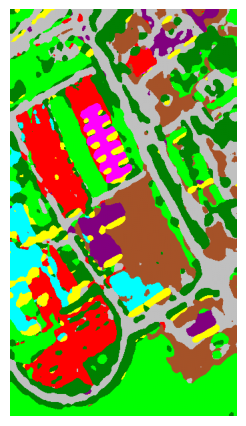

In [24]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './pu_mvit.pdf')

## t-SNE Visualization

In [25]:
def scatter(x, colors, num_classes=9):
    palette = np.array([[192, 192, 192], [0, 255, 1], [0, 255, 255], [0, 128, 1], [255, 0, 254], 
                        [165, 82, 40], [129, 0, 127], [255, 0, 0], [255, 255, 0]])/255.
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_mvit.pdf', bbox_inches='tight')

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_codings = []
test_tar = []
for batch_idx, (image, label) in enumerate(test_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        final_features = ActivationOutputData(model.norm)  # (1, 400, 8)
        _ = model(image)
        final_features.remove()
    test_codings.append(final_features.outputs.cpu().data)
    test_tar.append(label.cpu().data)

x_test = torch.concat(test_codings)
y_test = torch.concat(test_tar)

x_test_numpy = x_test.numpy()
y_test_numpy = y_test.numpy()

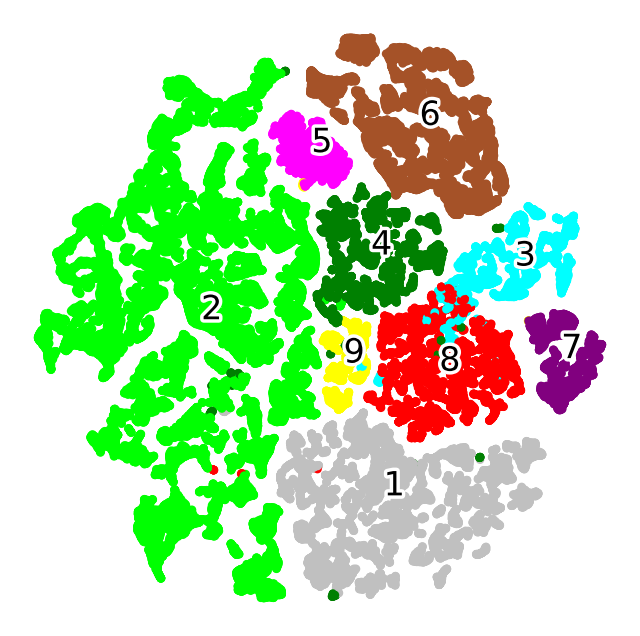

In [27]:
tsne_proj = TSNE(random_state=42).fit_transform(x_test_numpy)

scatter(tsne_proj, y_test_numpy)